In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


In [44]:
art_data = pd.read_csv("Artificial_trend.csv")
art_data.set_index('date',inplace=True)
len(art_data)

7307

In [ ]:
#since data already ranges from -0.15 to 0.15, omit minmaxscale
# Define lookback period and split inputs/labels

# Scaling the input data
# sc = MinMaxScaler()
# label_sc = MinMaxScaler()
# data = sc.fit_transform(art_data.values)
# # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
# label_sc.fit(art_data.iloc[:,0].values.reshape(-1,1))

In [45]:
def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

lookback = 30 # choose sequence length
train_x,train_y,test_x,test_y = split_data(art_data.values, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (5822, 30, 1)
y_train.shape:  (5822, 1)
X_test.shape:  (1455, 30, 1)
y_test.shape:  (1455, 1)


In [46]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [47]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden
    
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):

    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):

        h = model.init_hidden(batch_size)
        avg_loss = 0.
        for x, label in train_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            
            loss = criterion(out, label.float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        #print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        #epoch_times.append(current_time-start_time)
    #print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        h = model.init_hidden(1)
        criterion = nn.MSELoss()
        for x, label in test_loader:
            h = h.data
            model.zero_grad()
            #print(x.float().shape,h.shape)
            #print(x.float(),h)
            out, h = model.forward(x.float(), h)
            loss = criterion(out, label.float())
            loss = loss.item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))

    return predictions, values, loss

In [48]:
lr = 0.001
gru_model1 = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1/5 Done, Total Loss: 0.0011017555272297209
Epoch 2/5 Done, Total Loss: 4.2565305031732555e-05
Epoch 3/5 Done, Total Loss: 3.489908020936936e-05
Epoch 4/5 Done, Total Loss: 3.658609833413114e-05
Epoch 5/5 Done, Total Loss: 2.903606853376712e-05


In [49]:
predictions, values, loss = evaluate(gru_model1,test_loader)
print("testing set loss: {}".format(loss))

testing set loss: 4.0652357711223885e-05


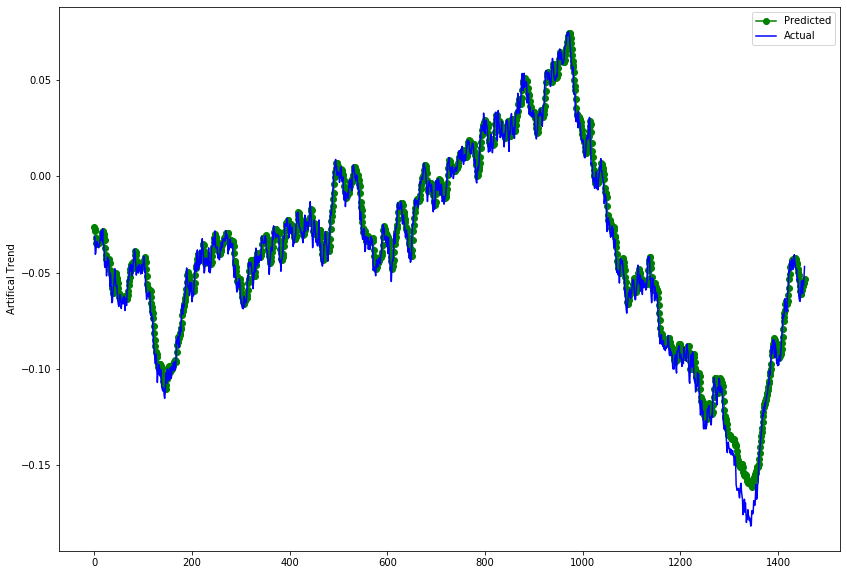

In [50]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Artifical Trend')
plt.legend()

## Microsoft Stock

In [51]:
microsoft_df = pd.read_csv("Microsoft_Stock.csv")
microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
microsoft_df.set_index('Date',inplace=True)
microsoft_df.drop(columns=['Open','High','Low','Volume'],inplace=True)
microsoft_df

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [52]:
# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
scaled_micro = sc.fit_transform(microsoft_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))

train_x,train_y,test_x,test_y = split_data(scaled_micro, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1185, 30, 1)
y_train.shape:  (1185, 1)
X_test.shape:  (296, 30, 1)
y_test.shape:  (296, 1)


In [53]:
batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [54]:
lr = 0.001
gru_model2 = train(train_loader, lr, model_type="GRU")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Starting Training of GRU model
Epoch 1/5 Done, Total Loss: 0.028073999823795423
Epoch 2/5 Done, Total Loss: 0.007599919822597358
Epoch 3/5 Done, Total Loss: 0.0007847840550109848
Epoch 4/5 Done, Total Loss: 0.00018075738828176528
Epoch 5/5 Done, Total Loss: 0.00013044508321197808


testing set loss: 3.120171095361002e-05


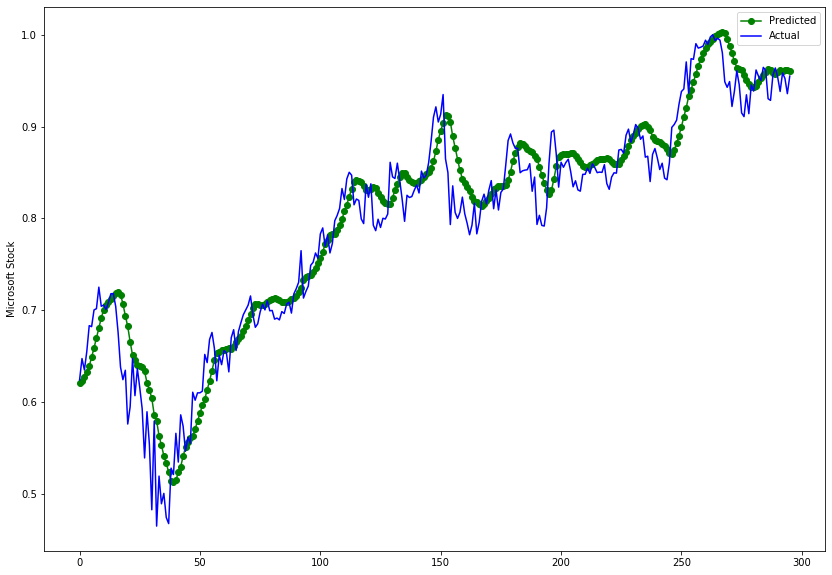

In [55]:
predictions, values,loss = evaluate(gru_model2,test_loader)
print("testing set loss: {}".format(loss))
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('Microsoft Stock')
plt.legend()